Cell 1: Install Required Libraries

In [15]:
# Install Roboflow
!pip install roboflow

# Install PyTorch and TorchVision (compatible with CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install Detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html

# Install additional dependencies
!pip install opencv-python matplotlib seaborn

DEPRECATION: Loading egg at /home/rayhaan/.pyenv/versions/3.12.3/lib/python3.12/site-packages/detectron2-0.6-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/rayhaan/.pyenv/versions/3.12.3/lib/python3.12/site-packages/detectron2-0.6-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://download.pytorch.org/whl/cu118
DEPRECATION: Loading egg at /home/rayhaan/.pyenv/versions/3.12.3/lib/python3.12/site-packages/detectron2-0.6-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://gi

1. Imports and Logger Setup

In [16]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator
import os
import json
from datetime import datetime
import torch
from detectron2.utils.events import EventStorage
import logging
from collections import Counter

from roboflow import Roboflow

2. Roboflow Initialization

In [ ]:
# Initialize Roboflow with your API key
rf = Roboflow(api_key="replace_with_your_api_key")
project = rf.workspace("").project("")
version = project.version(10)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


3. Define Paths and Valid Categories

In [18]:
# Define paths
TRAIN_DIR = "/home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/train"
VALID_DIR = "/home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid"
TRAIN_JSON = "/home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/train/_annotations.coco.json"
VALID_JSON = "/home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid/_annotations.coco.json"

# Define valid categories
VALID_CATEGORIES = {
    "Tooth decay": 0,
    "bite block": 1,
    "braces": 2,
    "calculus": 3,
    "cervical burnout": 4,
    "filling": 5,
    "implant": 6,
    "tooth": 7,
    "wire": 8
}

4. Data Cleaning and Remapping Annotations

In [19]:
def clean_and_remap_annotations(json_file):
    """Clean the JSON annotations to only include valid categories"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    new_categories = [
        {"id": idx, "name": name, "supercategory": "dental"} 
        for name, idx in VALID_CATEGORIES.items()
    ]
    
    new_annotations = []
    for ann in data['annotations']:
        category_name = next(
            (cat['name'] for cat in data['categories'] if cat['id'] == ann['category_id']), 
            None
        )
        if category_name in VALID_CATEGORIES:
            ann_copy = ann.copy()
            ann_copy['category_id'] = VALID_CATEGORIES[category_name]
            new_annotations.append(ann_copy)
    
    cleaned_data = {
        "info": data["info"],
        "licenses": data["licenses"],
        "images": data["images"],
        "categories": new_categories,
        "annotations": new_annotations
    }
    
    return cleaned_data

5. Convert Dataset to Detectron2 Format

In [20]:
def get_dental_dicts(img_dir, ann_file):
    """Convert dataset to Detectron2 format"""
    print(f"Loading and cleaning annotations from: {ann_file}")
    cleaned_data = clean_and_remap_annotations(ann_file)
    
    dataset_dicts = []
    for img in cleaned_data['images']:
        record = {}
        
        filename = os.path.join(img_dir, img['file_name'])
        if not os.path.exists(filename):
            print(f"Warning: Image not found: {filename}")
            continue
            
        record["file_name"] = filename
        record["image_id"] = img['id']
        record["height"] = img['height']
        record["width"] = img['width']
        
        annos = []
        for ann in cleaned_data['annotations']:
            if ann['image_id'] == img['id']:
                obj = {
                    "bbox": ann['bbox'],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": ann['segmentation'],
                    "category_id": ann['category_id'],
                }
                annos.append(obj)
        record["annotations"] = annos
        dataset_dicts.append(record)
    
    print(f"Loaded {len(dataset_dicts)} images with valid annotations")
    return dataset_dicts

6. Custom Trainer with COCO Evaluator

In [21]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

7. Register Datasets with Detectron2

In [22]:
def register_datasets():
    """Register the datasets with Detectron2"""
    print("Registering datasets with cleaned categories...")
    
    for d in ["train", "val"]:
        dataset_name = f"dental_{d}"
        if dataset_name in DatasetCatalog:
            DatasetCatalog.remove(dataset_name)
        if dataset_name in MetadataCatalog:
            MetadataCatalog.remove(dataset_name)
    
    for d in ["train", "val"]:
        DatasetCatalog.register(
            f"dental_{d}", 
            lambda d=d: get_dental_dicts(
                TRAIN_DIR if d=="train" else VALID_DIR,
                TRAIN_JSON if d=="train" else VALID_JSON
            )
        )
        
        MetadataCatalog.get(f"dental_{d}").set(
            thing_classes=list(VALID_CATEGORIES.keys()),
            thing_colors=[(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 
                         for _ in VALID_CATEGORIES]
        )
    
    print("\nRegistered categories:")
    for name, idx in VALID_CATEGORIES.items():
        print(f"ID: {idx}, Name: {name}")

8. Model Training Configuration and Execution

In [23]:
def train_model():
    """Train the model"""
    register_datasets()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("dental_train",)
    cfg.DATASETS.TEST = ("dental_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(VALID_CATEGORIES)
    cfg.TEST.EVAL_PERIOD = 100
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    cfg.OUTPUT_DIR = f"./output_dental_{timestamp}"
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    print(f"\nModel configuration:")
    print(f"Number of classes: {len(VALID_CATEGORIES)}")
    print(f"Output directory: {cfg.OUTPUT_DIR}")
    
    trainer = CustomTrainer(cfg)
    trainer.resume_or_load(resume=False)
    
    print("\nStarting training...")
    return trainer, cfg

9. Inference and Visualization Functions


In [24]:
def perform_inference(cfg, dataset_name):
    """Perform inference and visualize results"""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        plt.figure(figsize=(12, 8))
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

def compare_ground_truth_and_predictions(dataset_name, predictor, num_samples=3):
    """Compare ground truth and predictions side by side"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    for d in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(d["file_name"])
        
        # Ground truth visualization
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
        vis_gt = visualizer.draw_dataset_dict(d)
        
        # Prediction visualization
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1],
                      metadata=metadata, 
                      scale=0.8, 
                      instance_mode=ColorMode.IMAGE_BW)
        vis_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        combined_img = np.hstack((vis_gt.get_image()[:, :, ::-1], vis_pred.get_image()[:, :, ::-1]))
        
        plt.figure(figsize=(20, 10))
        plt.imshow(combined_img)
        plt.axis('off')
        plt.title("Ground Truth (left) vs Predictions (right)")
        plt.show()

def analyze_class_distribution(dataset_name, predictor):
    """Analyze class distribution"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    gt_distribution = Counter()
    pred_distribution = Counter()
    
    for d in dataset_dicts:
        # Ground truth distribution
        for ann in d["annotations"]:
            class_name = metadata.thing_classes[ann["category_id"]]
            gt_distribution[class_name] += 1
        
        # Predicted distribution
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        pred_classes = outputs["instances"].pred_classes.cpu().numpy()
        for class_id in pred_classes:
            class_name = metadata.thing_classes[class_id]
            pred_distribution[class_name] += 1
    
    # Plot distributions
    classes = list(set(list(gt_distribution.keys()) + list(pred_distribution.keys())))
    gt_counts = [gt_distribution[c] for c in classes]
    pred_counts = [pred_distribution[c] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, gt_counts, width, label='Ground Truth')
    rects2 = ax.bar(x + width/2, pred_counts, width, label='Predictions')
    
    ax.set_ylabel('Number of Instances')
    ax.set_title('Class Distribution: Ground Truth vs Predictions')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detection rates
    print("\nDetection Rates by Class:")
    print("-" * 50)
    for class_name in classes:
        gt = gt_distribution[class_name]
        pred = pred_distribution[class_name]
        if gt > 0:
            detection_rate = (pred / gt) * 100
            print(f"{class_name:20s}: {detection_rate:6.2f}% ({pred}/{gt})")

10. Confusion Matrix Calculation and Visualization

In [25]:
def calculate_confusion_matrix(dataset_name, predictor):
    """Calculate and visualize confusion matrix"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    num_classes = len(metadata.thing_classes)
    
    confusion_matrix = np.zeros((num_classes, num_classes))
    
    for d in dataset_dicts:
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        
        pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        pred_classes = outputs["instances"].pred_classes.cpu().numpy()
        
        gt_boxes = np.array([ann["bbox"] for ann in d["annotations"]])
        gt_classes = np.array([ann["category_id"] for ann in d["annotations"]])
        
        for pred_idx, pred_box in enumerate(pred_boxes):
            if len(gt_boxes) > 0:
                ious = calculate_iou(pred_box, gt_boxes)
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] > 0.5:
                    confusion_matrix[gt_classes[max_iou_idx]][pred_classes[pred_idx]] += 1
    
    plt.figure(figsize=(12, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    classes = metadata.thing_classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(int(confusion_matrix[i, j]), 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def calculate_iou(box1, box2):
    """Calculate IoU between boxes"""
    box1 = np.array([box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]])
    box2 = np.array([[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in box2])
    
    x1 = np.maximum(box1[0], box2[:, 0])
    y1 = np.maximum(box1[1], box2[:, 1])
    x2 = np.minimum(box1[2], box2[:, 2])
    y2 = np.minimum(box1[3], box2[:, 3])
    
    intersection = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection
    
    return intersection / union

11. Training Curves Plotting

In [26]:
def plot_training_curves(cfg):
    """Plot training curves"""
    metrics_file = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
    
    iterations = []
    total_loss = []
    
    with open(metrics_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            if "total_loss" in data:
                iterations.append(data["iteration"])
                total_loss.append(data["total_loss"])
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, total_loss)
    plt.xlabel("Iterations")
    plt.ylabel("Total Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

12. Additional Utility Functions for Model Evaluation

In [27]:
def evaluate_model_thresholds(cfg, dataset_name, thresholds=[0.3, 0.5, 0.7]):
    """Evaluate model performance at different confidence thresholds"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    results = {}
    
    for threshold in thresholds:
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
        predictor = DefaultPredictor(cfg)
        
        total_gt = 0
        total_pred = 0
        correct_pred = 0
        
        for d in dataset_dicts:
            # Count ground truth
            total_gt += len(d["annotations"])
            
            # Get predictions
            img = cv2.imread(d["file_name"])
            outputs = predictor(img)
            predictions = outputs["instances"]
            total_pred += len(predictions)
            
            # Count correct predictions (IoU > 0.5)
            if len(predictions) > 0 and len(d["annotations"]) > 0:
                pred_boxes = predictions.pred_boxes.tensor.numpy()
                gt_boxes = np.array([ann["bbox"] for ann in d["annotations"]])
                
                for pred_box in pred_boxes:
                    ious = calculate_iou(pred_box, gt_boxes)
                    if np.max(ious) > 0.5:
                        correct_pred += 1
        
        precision = correct_pred / total_pred if total_pred > 0 else 0
        recall = correct_pred / total_gt if total_gt > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results[threshold] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    
    # Plot results
    thresholds = list(results.keys())
    metrics = ['precision', 'recall', 'f1']
    
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        values = [results[t][metric] for t in thresholds]
        plt.plot(thresholds, values, marker='o', label=metric.capitalize())
    
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Model Performance vs Confidence Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print detailed results
    print("\nDetailed Results by Threshold:")
    print("-" * 50)
    for threshold, metrics in results.items():
        print(f"\nThreshold: {threshold}")
        print(f"Precision: {metrics['precision']:.3f}")
        print(f"Recall: {metrics['recall']:.3f}")
        print(f"F1 Score: {metrics['f1']:.3f}")

def export_model_predictions(cfg, dataset_name, output_file):
    """Export model predictions to JSON file"""
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    predictions = []
    
    for d in dataset_dicts:
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        
        img_predictions = {
            "file_name": d["file_name"],
            "image_id": d["image_id"],
            "predictions": []
        }
        
        for i in range(len(instances)):
            pred = {
                "category": metadata.thing_classes[instances.pred_classes[i]],
                "score": float(instances.scores[i]),
                "bbox": instances.pred_boxes.tensor[i].tolist()
            }
            img_predictions["predictions"].append(pred)
        
        predictions.append(img_predictions)
    
    with open(output_file, 'w') as f:
        json.dump(predictions, f, indent=2)
    
    print(f"Predictions exported to: {output_file}")

13. Main Execution Pipeline

Starting dental structure detection pipeline...

Initiating model training...
Registering datasets with cleaned categories...

Registered categories:
ID: 0, Name: Tooth decay
ID: 1, Name: bite block
ID: 2, Name: braces
ID: 3, Name: calculus
ID: 4, Name: cervical burnout
ID: 5, Name: filling
ID: 6, Name: implant
ID: 7, Name: tooth
ID: 8, Name: wire

Model configuration:
Number of classes: 9
Output directory: ./output_dental_20241103_093950
[11/03 09:39:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias


Starting training...
[11/03 09:39:56 d2.engine.train_loop]: Starting training from iteration 0
[11/03 09:40:04 d2.utils.events]:  eta: 0:04:51  iter: 19  total_loss: 4.025  loss_cls: 2.388  loss_box_reg: 0.9827  loss_rpn_cls: 0.5643  loss_rpn_loc: 0.08649    time: 0.3041  last_time: 0.1784  data_time: 0.0195  last_data_time: 0.0063   lr: 4.9953e-06  max_mem: 1895M
[11/03 09:40:08 d2.utils.events]:  eta: 0:03:26  iter: 39  total_loss: 3.825  loss_cls: 2.287  loss_box_reg: 0.9837  loss_rpn_cls: 0.4557  loss_rpn_loc: 0.07752    time: 0.2500  last_time: 0.1710  data_time: 0.0158  last_data_time: 0.0078   lr: 9.9902e-06  max_mem: 1895M
[11/03 09:40:12 d2.utils.events]:  eta: 0:03:00  iter: 59  total_loss: 3.246  loss_cls: 2.016  loss_box_reg: 0.995  loss_rpn_cls: 0.2331  loss_rpn_loc: 0.05982    time: 0.2294  last_time: 0.1367  data_time: 0.0101  last_data_time: 0.0050   lr: 1.4985e-05  max_mem: 1895M
[11/03 09:40:15 d2.utils.events]:  eta: 0:02:46  iter: 79  total_loss: 3.076  loss_cls: 1

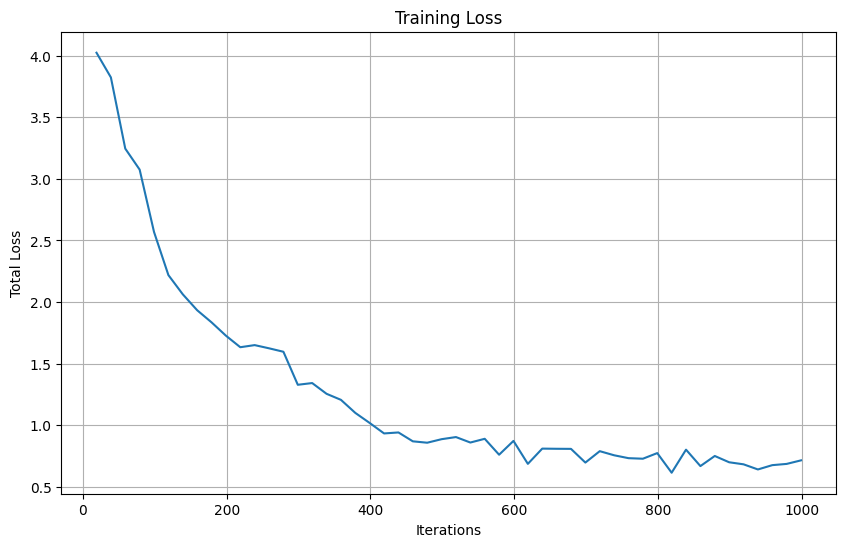


Visualizing inference results...
[11/03 09:44:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_dental_20241103_093950/model_final.pth ...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid/_annotations.coco.json
Loaded 107 images with valid annotations


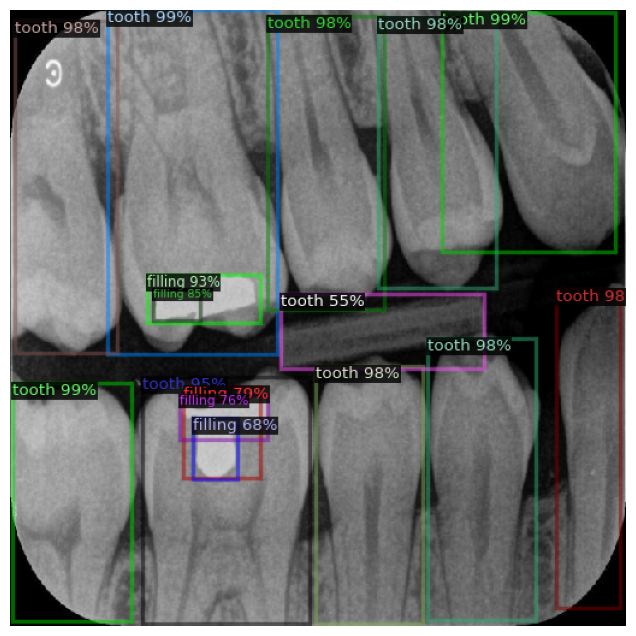

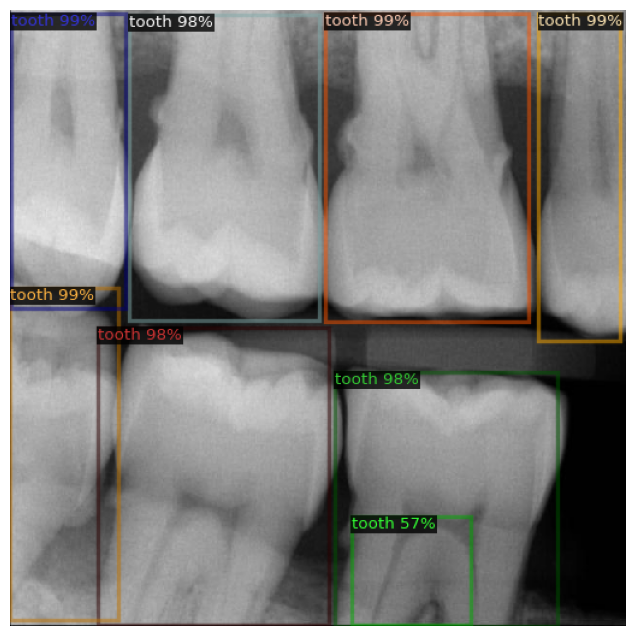

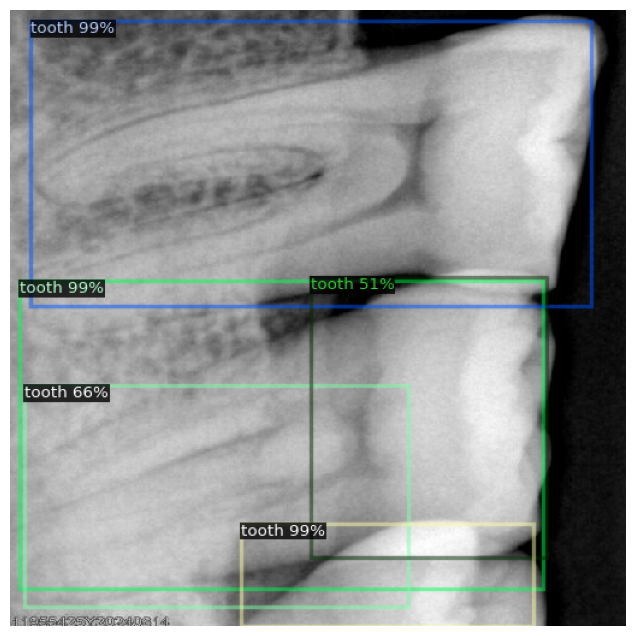


Comparing ground truth with predictions...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid/_annotations.coco.json
Loaded 107 images with valid annotations


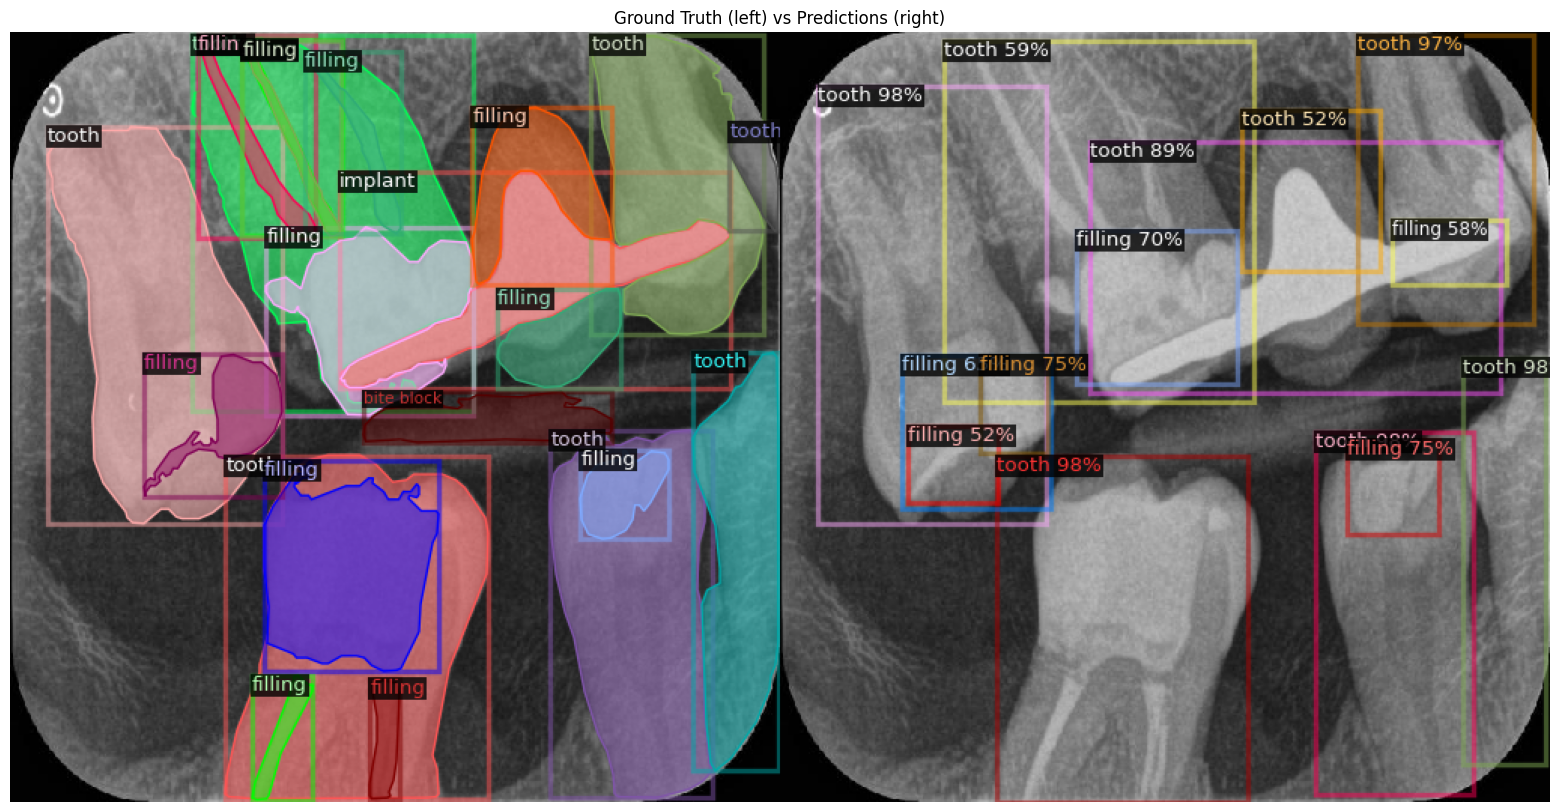

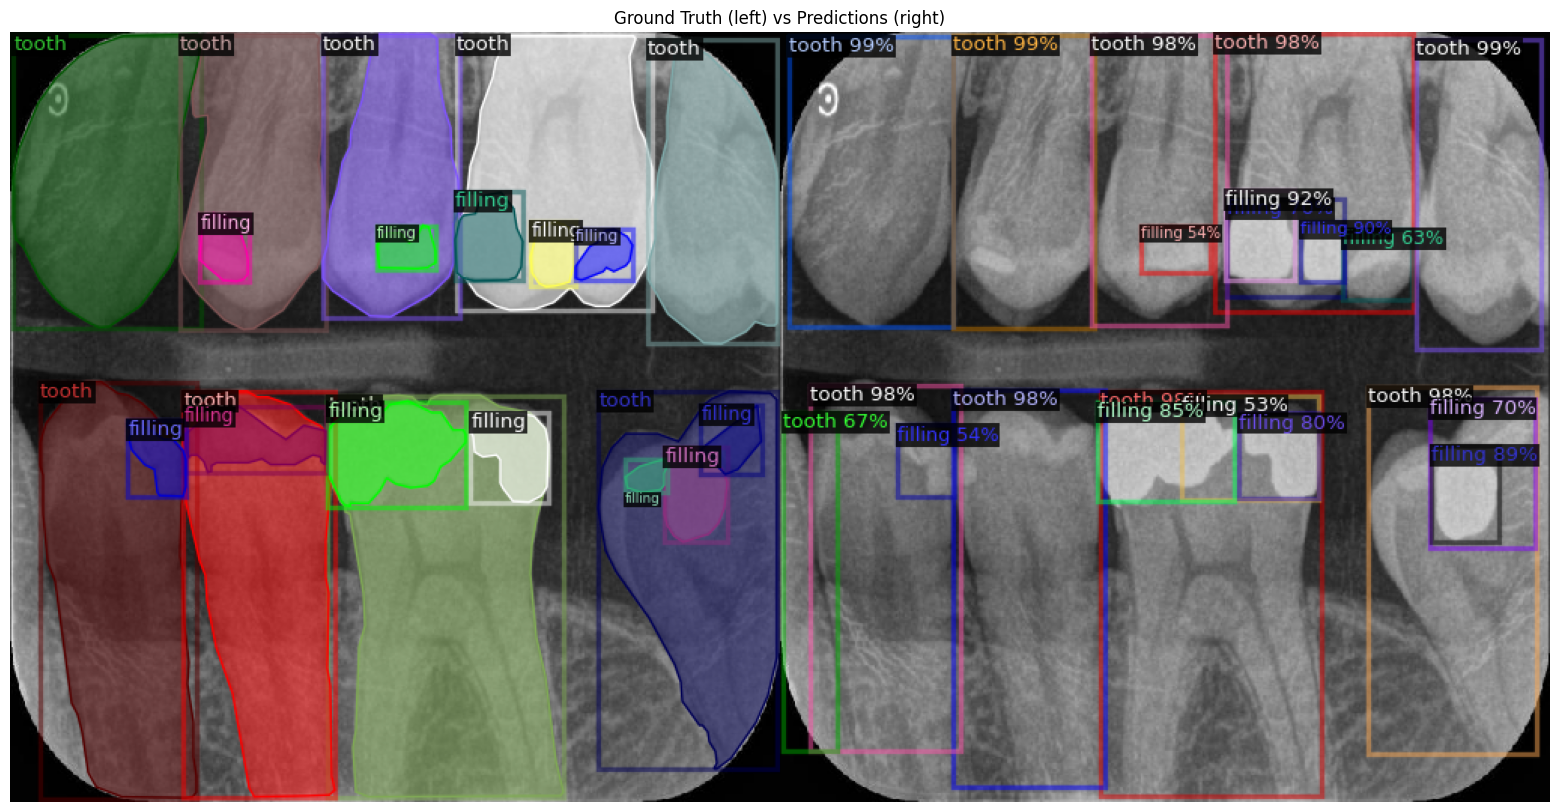

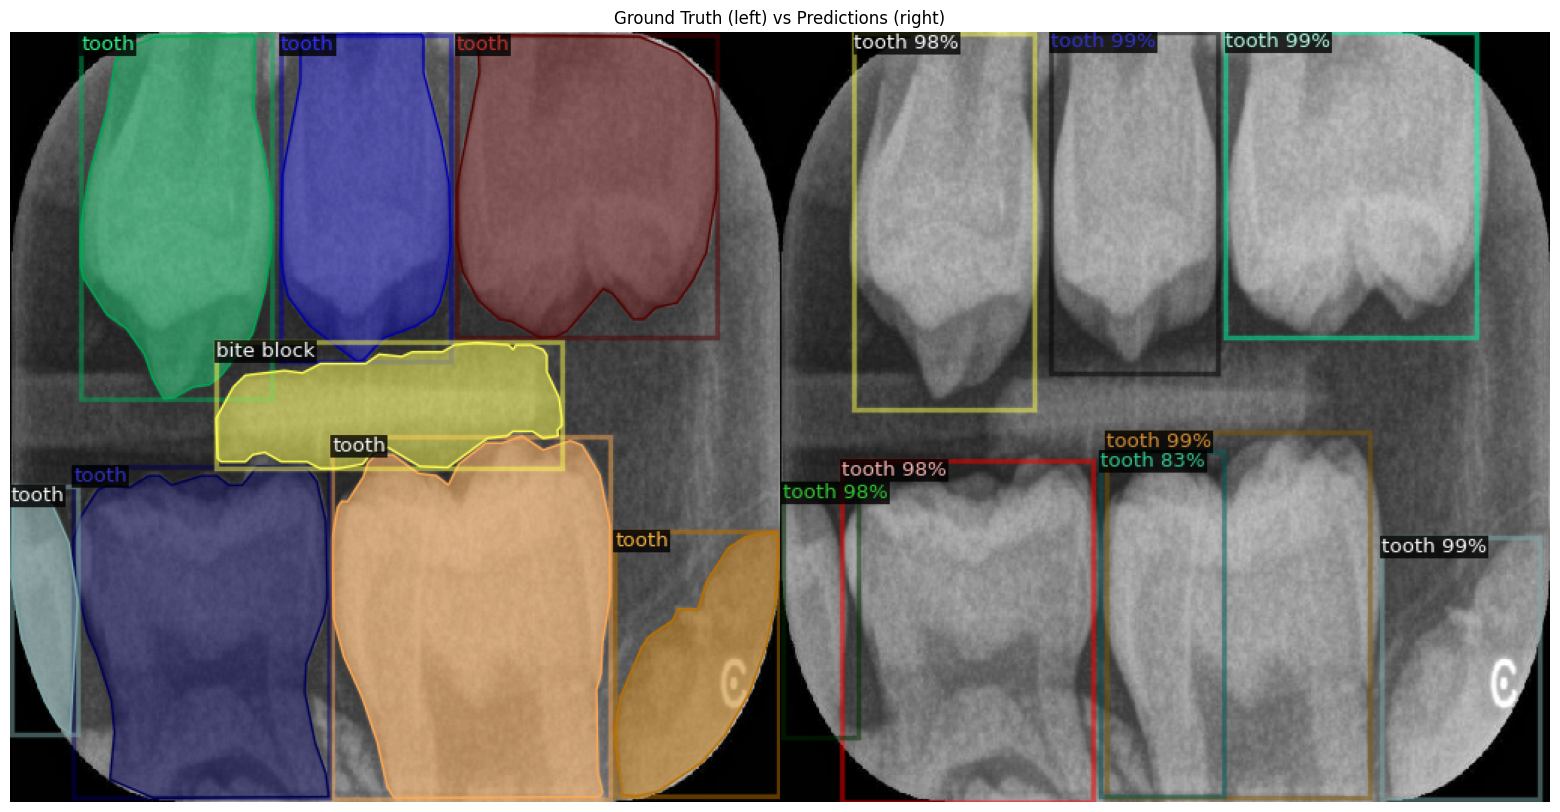


Analyzing class distribution...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid/_annotations.coco.json
Loaded 107 images with valid annotations


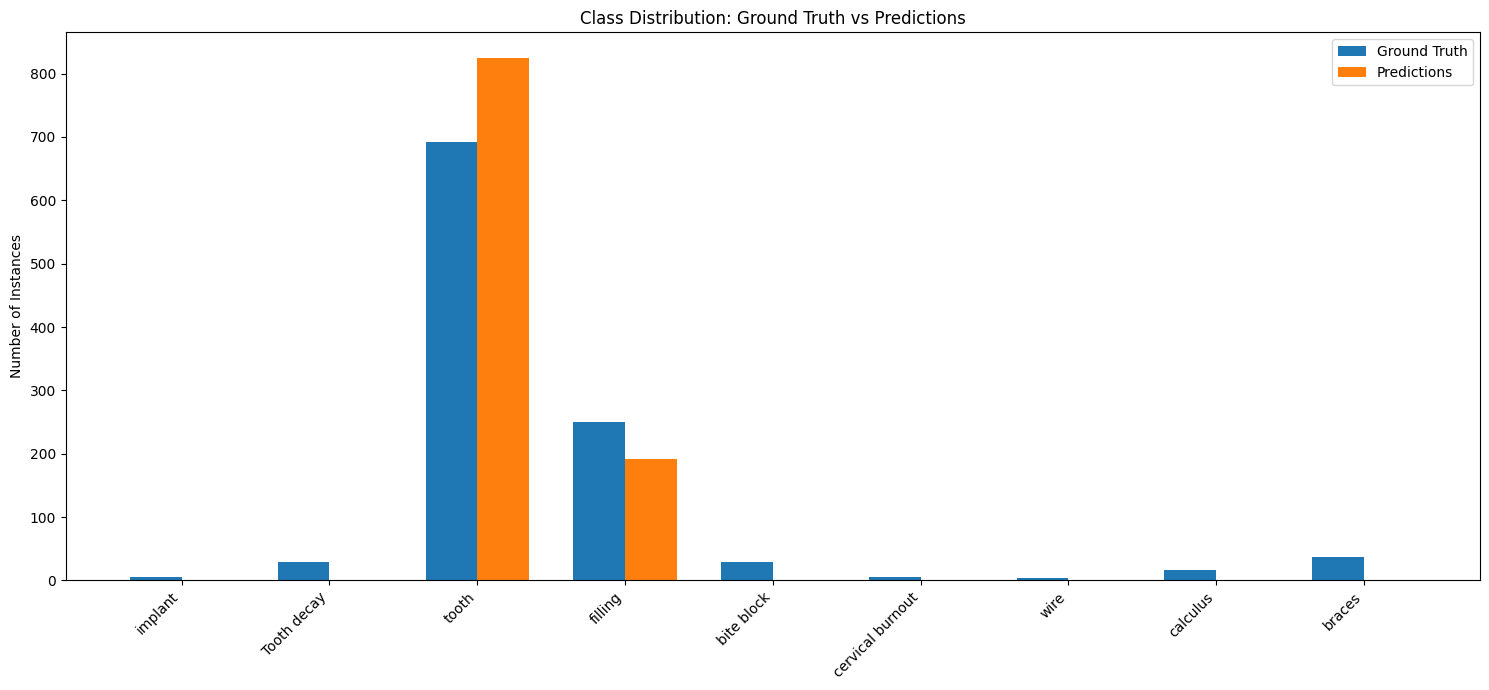


Detection Rates by Class:
--------------------------------------------------
implant             :   0.00% (0/6)
Tooth decay         :   0.00% (0/29)
tooth               : 119.08% (824/692)
filling             :  76.40% (191/250)
bite block          :   0.00% (0/29)
cervical burnout    :   0.00% (0/5)
wire                :   0.00% (0/3)
calculus            :   0.00% (0/16)
braces              :   0.00% (0/37)

Generating confusion matrix...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Dental-structure-detection-10/valid/_annotations.coco.json
Loaded 107 images with valid annotations


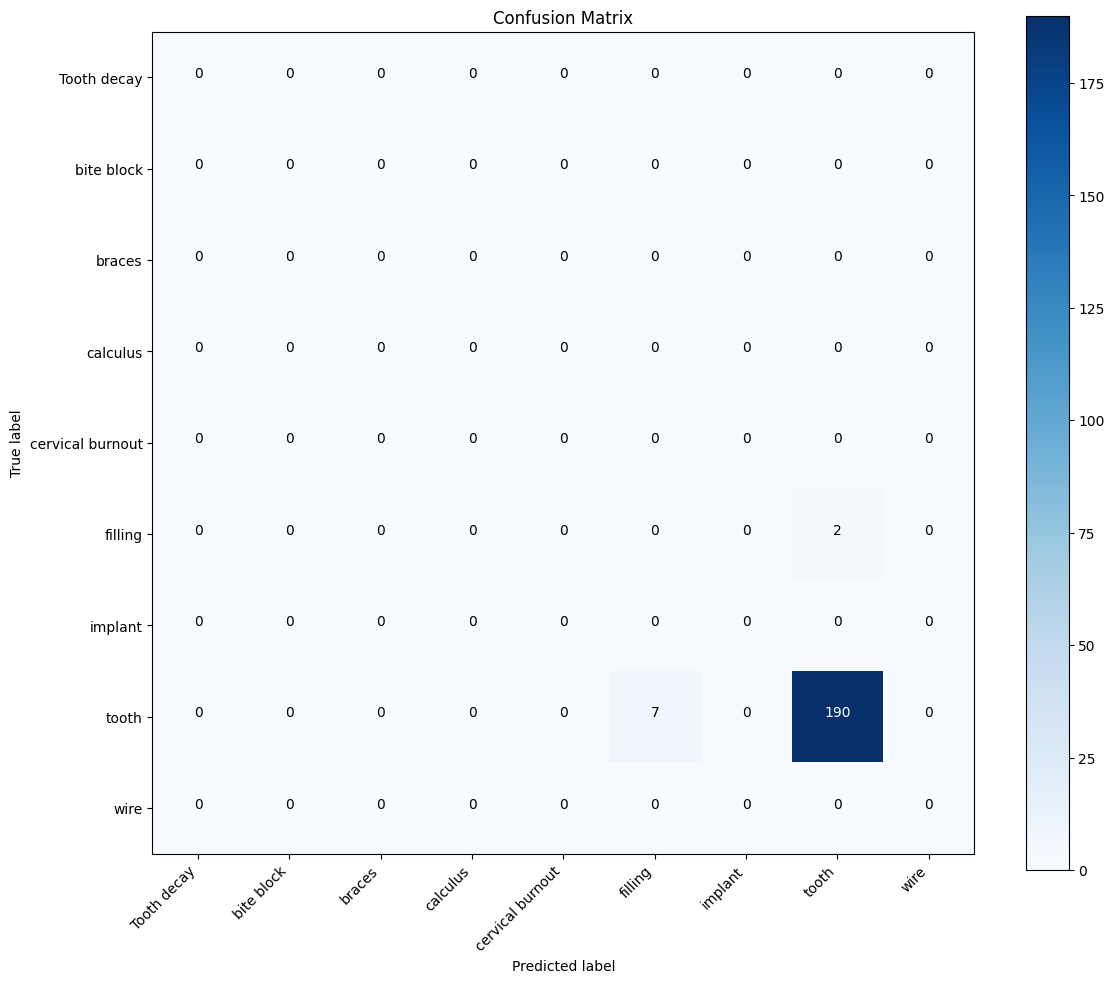

In [28]:
# Main execution
if __name__ == "__main__":
    print("Starting dental structure detection pipeline...")
    
    try:
        # Step 1: Verify paths
        for path in [TRAIN_DIR, VALID_DIR, TRAIN_JSON, VALID_JSON]:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Path not found: {path}")
        
        # Step 2: Train the model
        print("\nInitiating model training...")
        trainer, cfg = train_model()
        trainer.train()
        
        # Step 3: Create predictor for inference
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set testing threshold
        predictor = DefaultPredictor(cfg)
        
        # Step 4: Plot training curves
        print("\nPlotting training curves...")
        plot_training_curves(cfg)
        
        # Step 5: Perform inference visualization
        print("\nVisualizing inference results...")
        perform_inference(cfg, "dental_val")
        
        # Step 6: Compare ground truth vs predictions
        print("\nComparing ground truth with predictions...")
        compare_ground_truth_and_predictions("dental_val", predictor)
        
        # Step 7: Analyze class distribution
        print("\nAnalyzing class distribution...")
        analyze_class_distribution("dental_val", predictor)
        
        # Step 8: Calculate and visualize confusion matrix
        print("\nGenerating confusion matrix...")
        calculate_confusion_matrix("dental_val", predictor)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e